In [1]:
import os
import sys
root_dir = os.path.join(os.getcwd(), '../../')
if root_dir not in sys.path:
    sys.path.append(root_dir)
from spider_local import SPIDER
%reload_ext autoreload
%autoreload 2
op = SPIDER()
import anndata
import scanpy as sc
import pandas as pd
import numpy as np


In [2]:
adata = anndata.read_h5ad('./adata.h5ad')
adata

AnnData object with n_obs × n_vars = 428 × 19738
    obs: 'x', 'y', 'celltype', 'subtype', 'cluster'
    uns: 'moranI', 'spatial_neighbors'
    obsm: 'deconvolution', 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [ ]:
out_f # where to put the results
R_path # path to your R executor

In [4]:
idata = op.prep(adata, out_f, R_path, cluster_key='cluster', is_human=True, coord_type='grid', no_spatalk=True)

using spatalk result
no spatalk result, using all lrpairs
Using human LR pair dataset.
Running imputation with MAGIC
Calculating MAGIC...
  Running MAGIC on 428 cells and 790 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.17 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.05 seconds.
    Calculating affinities...
    Calculated affinities in 0.06 seconds.
  Calculated graph and diffusion operator in 0.29 seconds.
  Calculating imputation...
  Calculated imputation in 0.03 seconds.
Calculated MAGIC in 0.32 seconds.
scoring
using sqrt+max
Construct idata with 762 interfaces and 1100 LR pairs.


In [5]:
idata, meta_idata = op.find_svi(idata, out_f, R_path, overwrite=False, n_neighbors=5)

using 12*12 SOM nodes for 762 points
Added key nnSVG in idata.uns
Added key SOMDE in idata.uns
Added key SpatialDE in idata.uns
Added key SPARKX in idata.uns


2023-05-23 15:45:10.559307: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-23 15:45:10.561297: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-23 15:45:10.599252: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-23 15:45:10.600014: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 15:45:11.233144: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Added key scGCO in idata.uns
Added key moranI in idata.uns
Added key gearyC in idata.uns
finished running all SVI tests
Using the results from SVI identification methods: ['SOMDE' 'SpatialDE' 'SPARKX' 'nnSVG' 'scGCO' 'gearyC' 'moranI']
550/1100 SVIs identified (threshold=0.01).
Added key pattern_score in idata.obsm


In [ ]:
adata_sub = adata[adata.obs_names.isin(idata.uns['cell_meta'].index)]

Added key cell_pattern in idata.uns


/home/lishiying/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


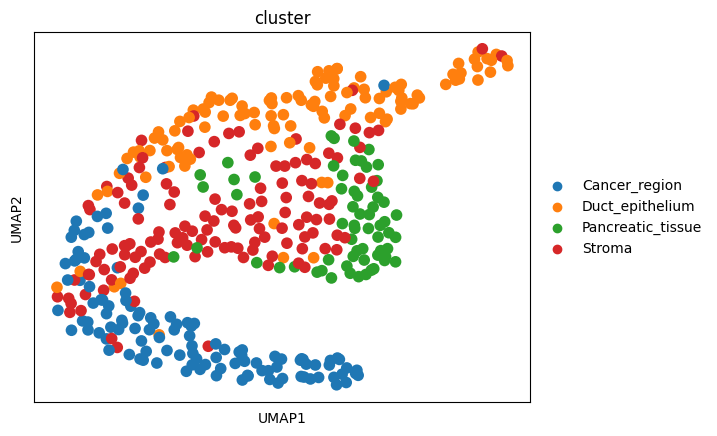

3 0.05
28 5.025
19 2.5375
11 1.29375
9 0.671875
6 0.3609375
9 0.51640625
7 0.438671875


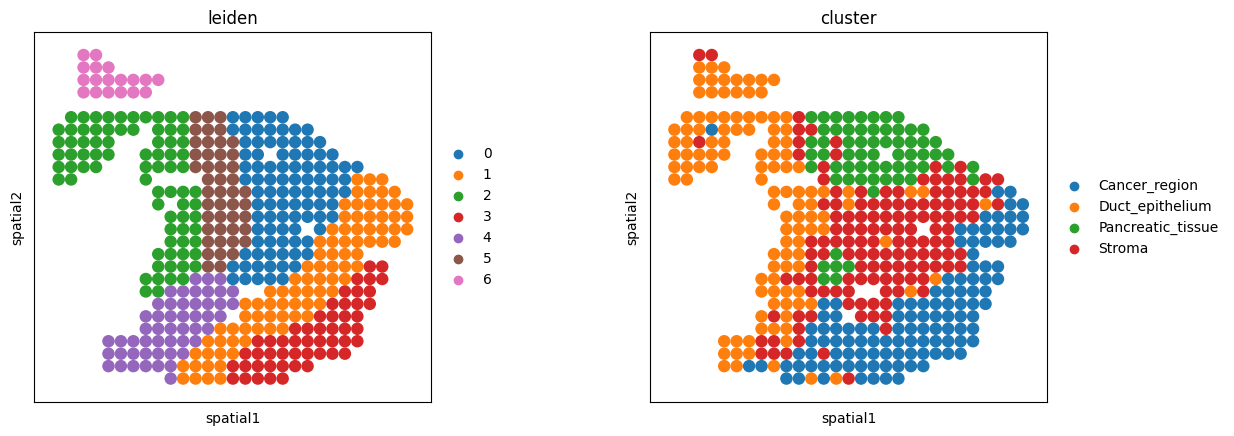

In [116]:
op.svi.idata_pattern_to_spot(idata)
op.cl.unsupervised_spot_clust(idata, adata_sub, n_cluster=7, n_neighbors=150)
sc.pl.umap(adata_sub, color='cluster')
sc.pl.spatial(adata_sub, color=['leiden', 'cluster'], spot_size=1)

In [76]:
adata_new=anndata.AnnData(idata.uns['cell_pattern'])
adata_new.obs=adata_sub.obs
adata_new.obsm['spatial'] = adata_sub.obsm['spatial']

/home/lishiying/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [77]:
def read_by_label(adata,label):
    pval_adj=pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'])[label]
    logfoldchanges=pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'])[label]
    names=pd.DataFrame(adata.uns['rank_genes_groups']['names'])[label]
    scores=pd.DataFrame(adata.uns['rank_genes_groups']['scores'])[label]
    df=pd.DataFrame({
        'pvals_adj':pval_adj,
        'logfoldchanges':logfoldchanges,
        'names':names,
        'scores':scores,
        
    })
    return df[df.logfoldchanges > 0.5]

In [78]:

adata_pattern=anndata.AnnData(adata_sub.obsm['deconvolution'].loc[adata_new.obs.index])
adata_pattern.obs=adata_sub.obs
adata_pattern.obsm['spatial'] = adata_sub.obsm['spatial']
sc.tl.rank_genes_groups(adata_pattern, 'leiden', method='wilcoxon')

In [79]:
read_by_label(adata_pattern, '1')

,pvals_adj,logfoldchanges,names,scores
0,5.931947e-19,1.805106,Cancer_clone_A,9.202740
1,1.215055e-12,1.203741,Cancer_clone_B,7.393561
2,4.148501e-04,0.635146,Macrophages_A,3.695301


In [ ]:
sc.pl.spatial(adata_pattern, color=read_by_label(adata_pattern, '1').names.to_numpy()[:5], spot_size=1)

In [57]:
read_by_label(adata_pattern, '5')

,pvals_adj,logfoldchanges,names,scores
0,5.797019e-08,1.094471,Ductal_,5.910534
1,5.313257e-07,1.533690,Mast_cells,5.411471
2,7.105697e-02,0.615193,pDCs,2.179983


In [ ]:
sc.pl.spatial(adata_pattern, color=read_by_label(adata_pattern, '5').names.to_numpy()[:5], spot_size=1)

marker LRI

In [84]:
op.util.interaction_spot_interface(idata)

Added key cell_score in idata.uns


In [87]:
adata_new=anndata.AnnData(idata.uns['cell_score'])
adata_new.obs=adata_sub.obs
adata_new.obsm['spatial'] = adata_sub.obsm['spatial']

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/lishiying/.local/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


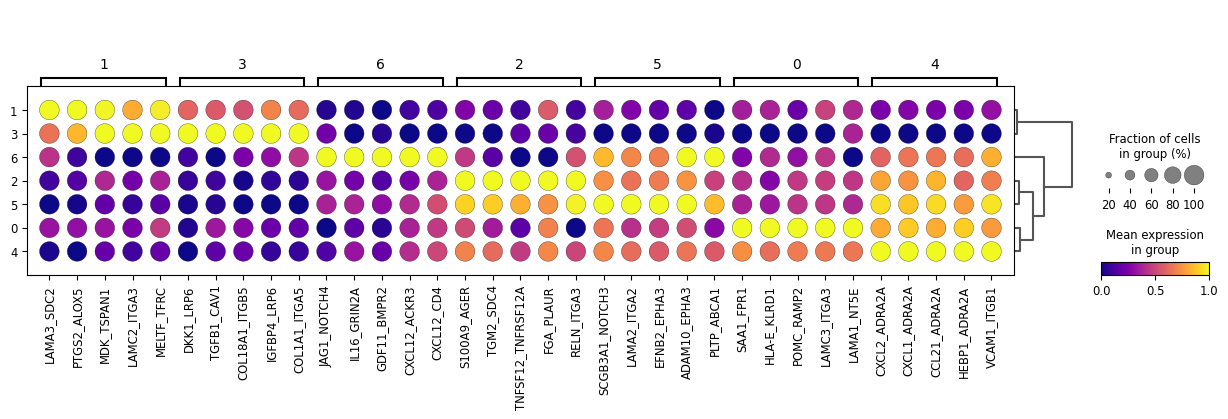

In [88]:
sc.tl.rank_genes_groups(adata_new, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata_new,n_genes=5, standard_scale='var',cmap='plasma')

In [97]:
read_by_label(adata_new, '3').sort_values('logfoldchanges', ascending =False)

,pvals_adj,logfoldchanges,names,scores
8,3.510382e-22,41.490612,LAMC2_ITGB4,10.128044
9,3.791671e-22,32.684776,LAMC2_CD151,10.113248
22,3.538244e-21,30.329077,LAMB3_ITGB4,9.779822
3,2.934446e-22,29.960236,LAMC2_ITGA3,10.236556
40,2.365545e-20,23.424078,LAMB3_CD151,9.519395
...,...,...,...,...
313,5.071180e-04,0.527103,TNFSF10_TNFRSF10B,3.526615
356,1.008809e-01,0.525580,COL3A1_DDR2,1.676992
98,1.602340e-16,0.524312,SFTPD_LY96,8.417513
317,9.540495e-04,0.519066,LAMC1_ITGA1,3.352011


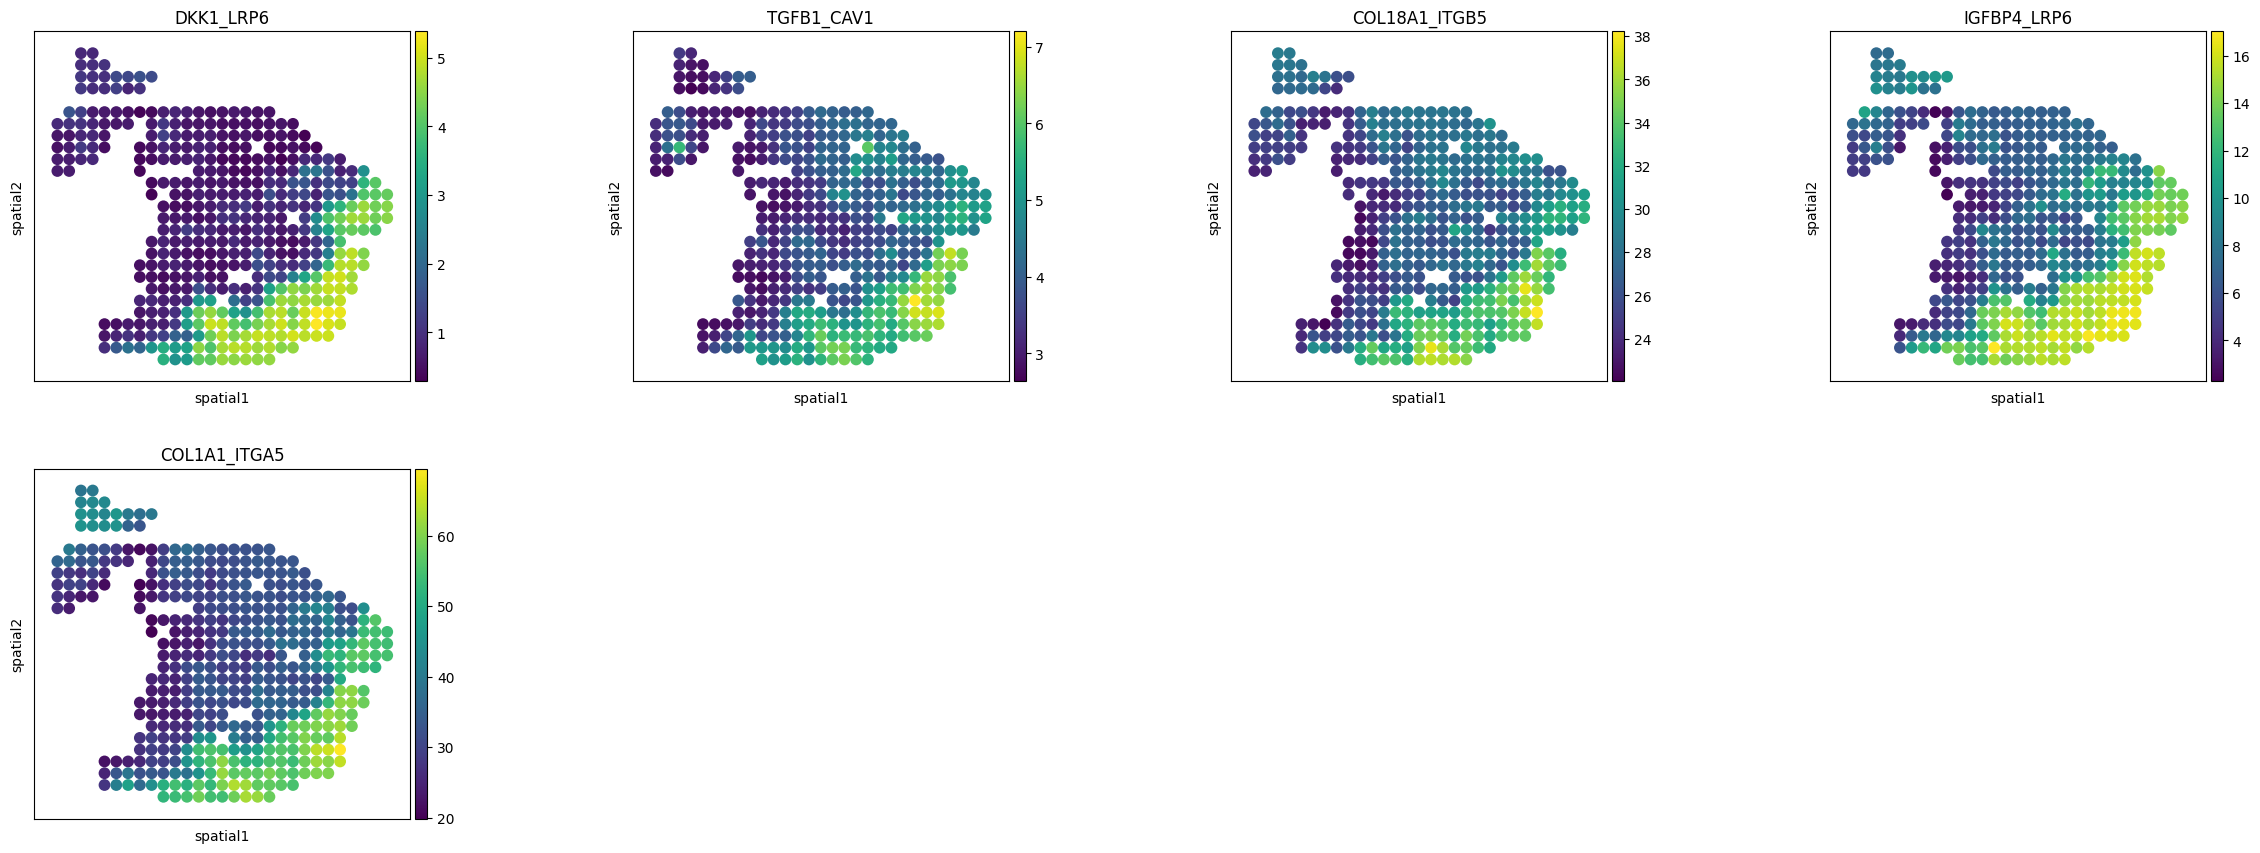

In [107]:
sc.pl.spatial(adata_new, color=read_by_label(adata_new, '3')['names'][:5], spot_size=1)

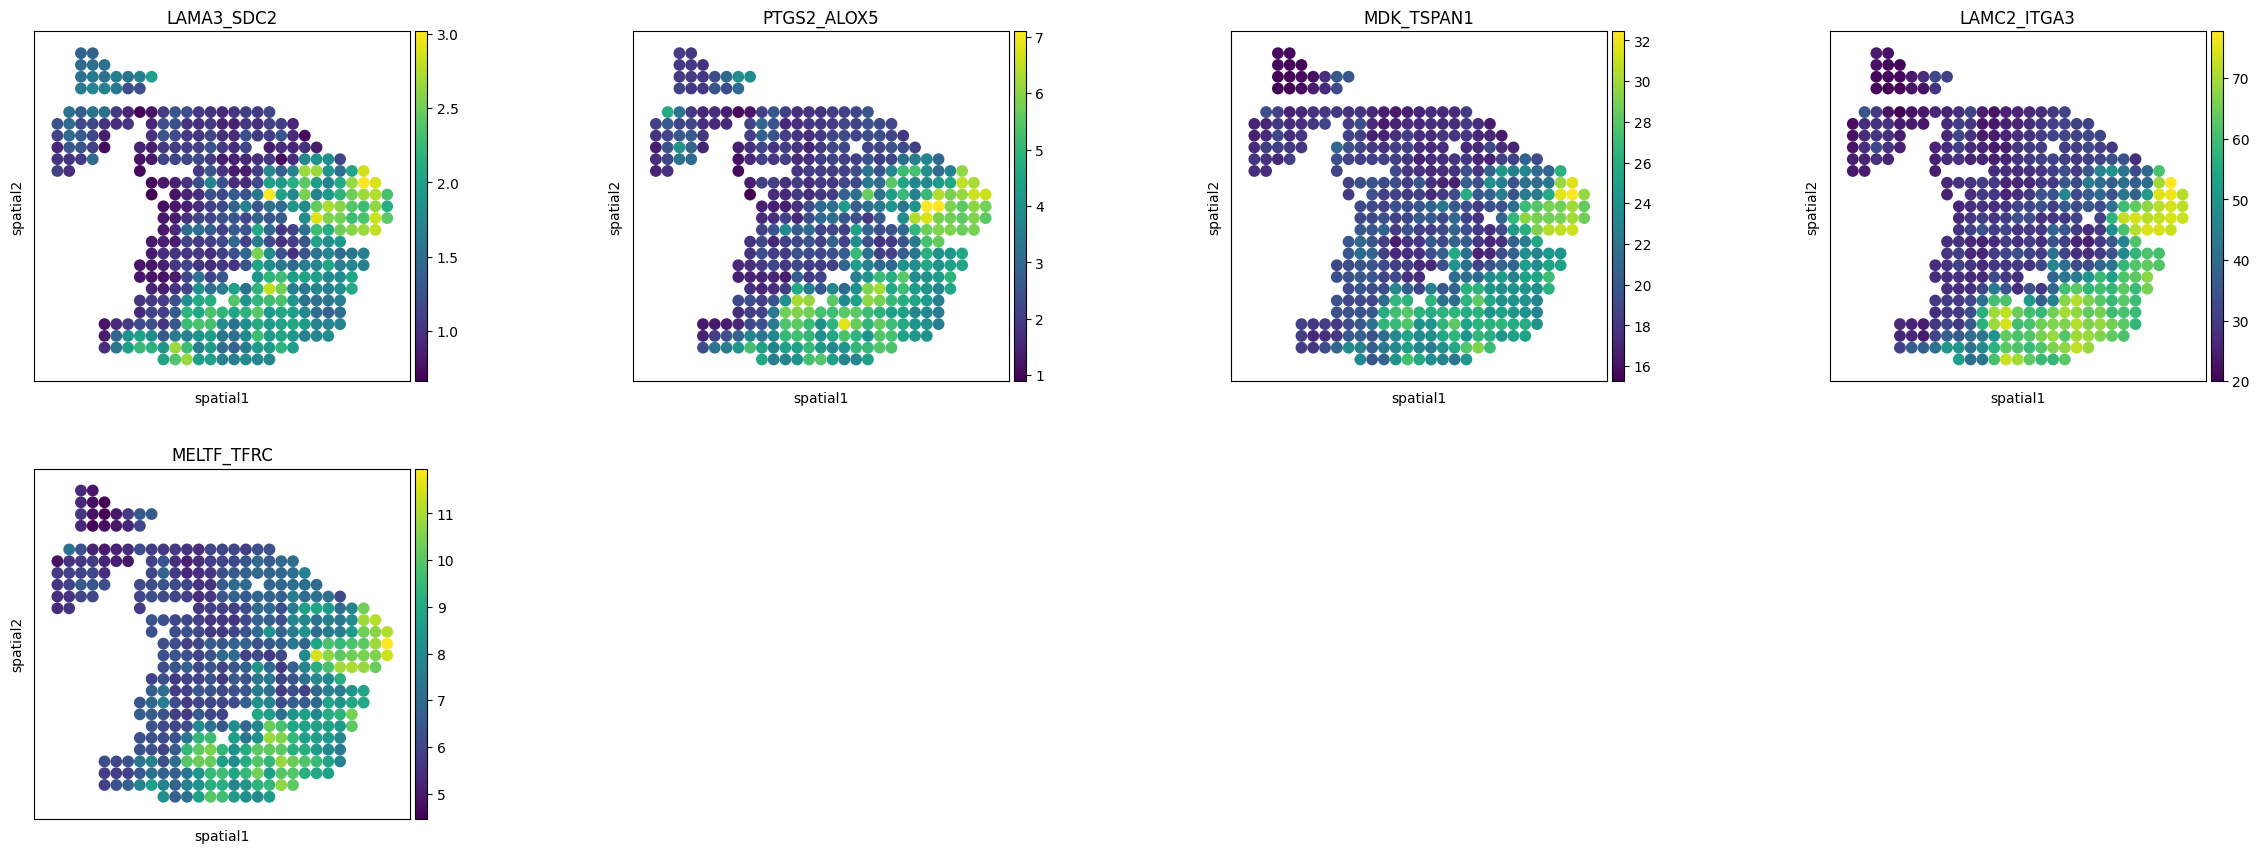

In [108]:
sc.pl.spatial(adata_new, color=read_by_label(adata_new, '1')['names'][:5], spot_size=1)

In [109]:
lri_df = []
for label in range(7):
    df=read_by_label(adata_new, str(label))
    df=df[df['logfoldchanges']>0.5]
    df['label']=label
    lri_df.append(df)
lri_df=pd.concat(lri_df)
custom, background=op.er.pathway_prep_custom_background(idata.var_names)
lri_df['g']=lri_df['names']
lri_df['membership']=lri_df['logfoldchanges']
merged_df, arr = op.er.enrichment(custom, background,lri_df,groupby='label')

Using human LR pair dataset.


In [110]:
merged_df_sub=merged_df[merged_df['P-value']<0.05]
irre=['Small cell lung cancer','Gastric acid secretion', 'Toxoplasmosis', 'Human immunodeficiency virus 1 infection','Morphine addiction','Human cytomegalovirus infection','Neuroactive ligand-receptor interaction',
       'Human papillomavirus infection','Yersinia infection','Amyotrophic lateral sclerosis (ALS)', 'Non-alcoholic fatty liver disease', 'Breast cancer','Olfactory transduction',
 'Non-alcoholic fatty liver disease (NAFLD)', 'Hepatitis B', 'Prostate cancer',
       ]
merged_df_sub=merged_df_sub[~merged_df_sub.Term.isin(irre)]

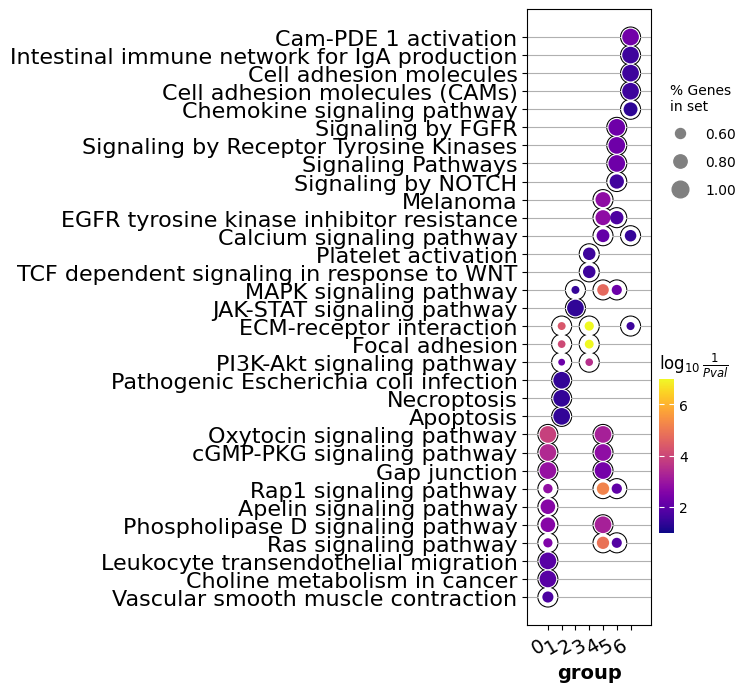

In [115]:
op.vis.enrichment(merged_df_sub, x_key ='group', size=2, top_term=10, figsize=(2, 8))

interface trajectory

In [ ]:
op.traj.smooth_pattern(idata)

/home/lishiying/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


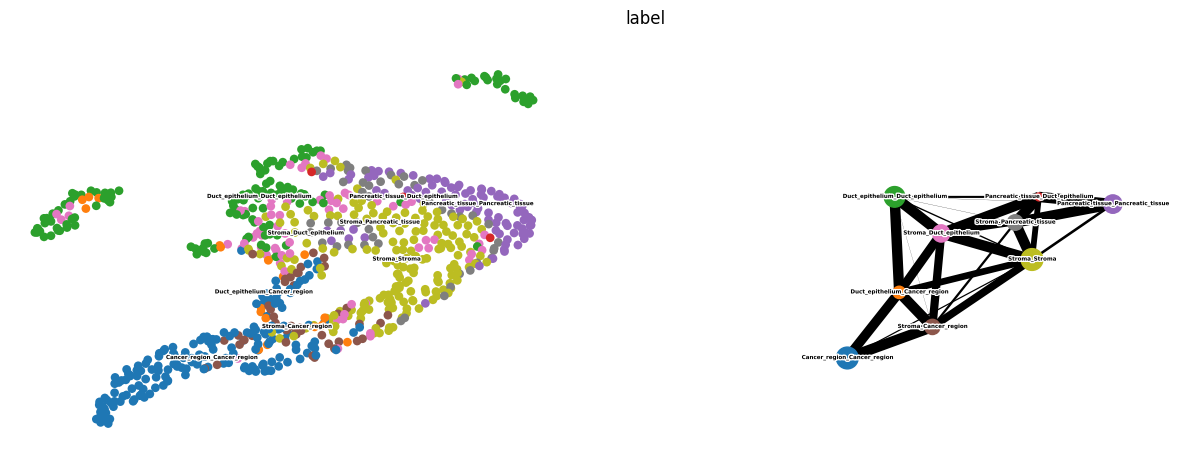

In [121]:
op.traj.paga(idata, 'label')
sc.pl.paga_compare(idata, legend_fontoutline=2, legend_fontsize=4)

In [145]:
sc.tl.rank_genes_groups(idata, 'label', method='wilcoxon')

In [140]:
paths = ['Cancer_region_Cancer_region', 'Stroma_Cancer_region', 'Stroma_Stroma']

In [155]:
lri_marker = []
for label in ['Cancer_region_Cancer_region', 'Stroma_Cancer_region', 'Stroma_Stroma']:
    df=read_by_label(idata, str(label))
    df=df[df['logfoldchanges']>0.5][:10]
    lri_marker.append(df.names.to_numpy())
lri_marker = np.array(lri_marker).flatten()

In [21]:
op.traj.pseudotime(idata, 'Cancer_region_Cancer_region')

/home/lishiying/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/paga.py:1229: UserWarning: FixedFormatter should only be used together with FixedLocator
  groups_axis.set_yticklabels(['', xlabel, ''], fontsize=ytick_fontsize)
/home/lishiying/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/paga.py:1276: UserWarning: FixedFormatter should only be used together with FixedLocator
  anno_axis.set_yticklabels(['', anno, ''], fontsize=ytick_fontsize)


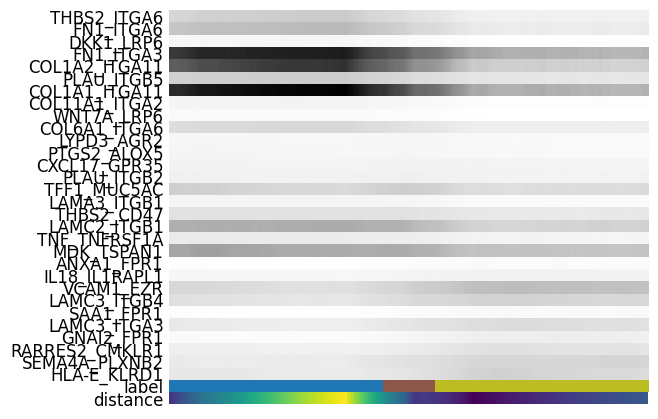

In [156]:
ipath=0
idata.obs['distance'] = idata.obs['dpt_pseudotime']
_, data = sc.pl.paga_path(
    idata, paths, keys=lri_marker,
    show_node_names=False,
    ytick_fontsize=12,
    left_margin=0.15,
    n_avg=50,
    annotations=['distance'],
    show_yticks=True if ipath==0 else False,
    show_colorbar=False,
    color_map='Greys',
    color_maps_annotations={'distance': 'viridis'},
    return_data=True,
    show=False)

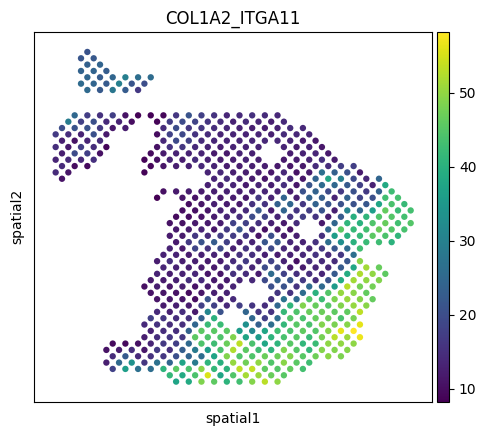

In [154]:
sc.pl.spatial(idata, color='COL1A2_ITGA11', spot_size=0.5)

In [23]:
op.traj.projection(idata)

100%|██████████| 762/762 [00:00<00:00, 4377.23cell/s]


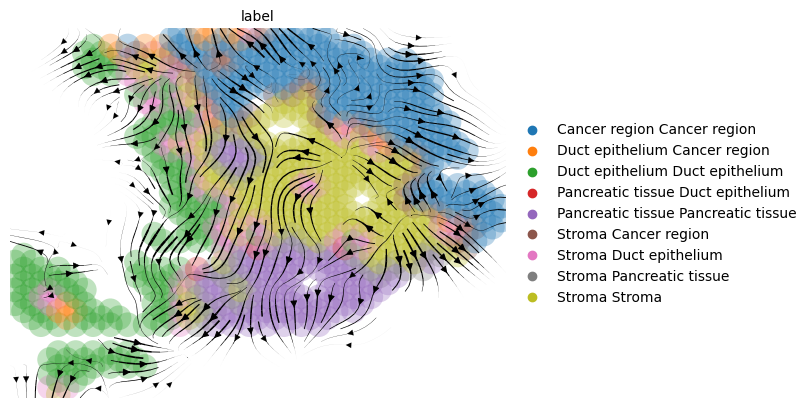

In [80]:
op.vis.traj_proj(idata, 'label')